# Enhancing Deep Fake Detection in Multimedia: A Fusion of CNN and RNN Approaches

## 1.2 Training the Model using Transfer Learning Approach (Xception)

In section 1.2, the utilization of transfer learning is implemented to incorporate the Xception model for the identification of falsely generated media.

To obtain references for this specific task, please follow the provided link: https://www.kaggle.com/code/krooz0/deep-fake-detection-on-images-and-videos

## Importing the Libraries

In [1]:
import cv2
import sys
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import Xception
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## Path to Dataset

The dataset is obtained from Kaggle, and you can access it by visiting the provided link: https://www.kaggle.com/datasets/dagnelies/deepfake-faces

The dataset comprises two components: a metadata CSV file and a "faces_224" folder. The metadata.csv file contains information about each image within the "faces_224" folder, specifically indicating whether an image is classified as "Real" or "Fake." The "videoname" column in the metadata file lists the names of the images corresponding to the ones in the "faces_224" folder. Additionally, the "label" column specifies the class to which each image belongs, either "Fake" or "Real."

In [2]:
def get_data():
    return pd.read_csv('/Path/metadata.csv')
meta = get_data()
meta.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [3]:
shape = meta.shape
print(f"Total Number of rows in the Metadata set: {shape[0]}")

len_FAKE = len(meta[meta.label == 'FAKE'])
len_REAL = len(meta[meta.label == 'REAL'])

print(f"The total number of 'REAL' samples in faces_224 folder: {len_REAL}")
print(f"The total number of 'FAKE' samples in faces_224 folder: {len_FAKE}")

Total Number of rows in the Metadata set: 95634
The total number of 'REAL' samples in faces_224 folder: 16293
The total number of 'FAKE' samples in faces_224 folder: 79341


Given the prevalence of more Fake images compared to Real images, we opt for undersampling to address the imbalanced dataset. In this approach, we create a balanced sample with a total size of 16000, evenly distributing 8000 images for each class.

In [4]:
real_labels = meta[meta["label"] == "REAL"]
fake_labels = meta[meta["label"] == "FAKE"]

#Creating a sample size of 8000 images in each Real and Fake classes, in total of 16000 images
sample_size = 8000

real_labels = real_labels.sample(sample_size)
fake_labels = fake_labels.sample(sample_size)

sample_metadata = pd.concat([real_labels, fake_labels])

This code splits the sample_metadata into training and testing sets using the train_test_split method, with a test size of 20% and stratification based on the 'label' column. Subsequently, the training set is further divided into training and validation sets with a 70-30 split ratio, again employing stratification based on the 'label'.

In [5]:
Training_set, Testing_set = train_test_split(sample_metadata,
                                             test_size = 0.2,
                                             stratify = sample_metadata['label'])

Training_set, Validation_set  = train_test_split(Training_set,
                                                 test_size = 0.3,
                                                 stratify = Training_set['label'])

print("Number of samples in Training Set:", len(Training_set))
print("Number of samples in Testing Set:", len(Testing_set))

Number of samples in Training Set: 8960
Number of samples in Testing Set: 3200


## Combining the Dataset

To generate image datasets, including X_train, X_test, X_val, along with their corresponding labels (y_train, y_test, y_val). The process involves partitioning the provided datasets, namely Training_set and Testing_set, and an additional Validation_set. Images are read, converted into NumPy arrays, and labeled based on the 'label' column extracted from the metadata.csv file. The label encoding strategy designates 0 for 'REAL' and 1 for 'FAKE'.

The load_dataset method is utilized to streamline the process of loading and preprocessing images, facilitating the training of the model with input images and their associated labels. This step is pivotal in preparing the data for subsequent model training and evaluation.

In [6]:
def load_dataset(set_name):
    images = []
    labels = []
    for index, row in set_name.iterrows():
        img_path = os.path.join('/Path/faces_224',
                                row['videoname'][:-4] + '.jpg')

        img = cv2.imread(img_path)
        images.append(img)
        labels.append(0 if row['label'] == 'REAL' else 1)
    return np.array(images), np.array(labels)

In [7]:
X_train, y_train = load_dataset(Training_set)
X_val,y_val = load_dataset(Validation_set)
X_test, y_test = load_dataset(Testing_set)

In [8]:
train_set_raw = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_set_raw = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_set_raw = tf.data.Dataset.from_tensor_slices((X_test, y_test))

This creates TensorFlow datasets, namely "train_set_raw", "valid_set_raw", and "test_set_raw", from NumPy arrays representing the training, validation, and testing sets, respectively. The TensorFlow "from_tensor_slices" method is employed to convert the NumPy arrays into slices that can be directly used in TensorFlow datasets. The resulting datasets are structured to contain pairs of input images and their corresponding labels, with "X_train" and "y_train" contributing to "train_set_raw", "X_val" and "y_val" contributing to "valid_set_raw", and "X_test" and "y_test" contributing to "test_set_raw". These datasets are now ready for use in training, validation, and testing processes within a TensorFlow environment.

In [9]:
batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

Creating a batch size of 32 and utilizes TensorFlow's Xception preprocessing function (preprocess_input) to preprocess the raw datasets (train_set_raw, valid_set_raw, and test_set_raw). For the training set (train_set), the data is first mapped to apply preprocessing to each element, then shuffled with a buffer size of 1000, batched into groups of 32, and finally prefetched for optimization. Similarly, the validation and test sets (valid_set and test_set) are mapped and batched, without shuffling, to prepare them for evaluation. The entire process ensures that the datasets are appropriately preprocessed and organized for training and validation in a TensorFlow environment.

## Data Augmentation

Using TensorFlow's Keras Sequential model, a data augmentation pipeline is implemented, incorporating three augmentation layers: horizontal flipping, rotation, and contrast adjustment. The primary goal of this pipeline is to enhance the training dataset by introducing diverse variations, ultimately improving the model's ability to generalize.

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    tf.keras.layers.RandomRotation(factor = 0.05),
    tf.keras.layers.RandomContrast(factor = 0.2)
])

## Importing the Xception Model

The variable "XCEPTION_MODEL" is assigned the Xception model with pre-trained ImageNet weights and excluding the top classification layer.

#### About Xception
Xception, introduced by François Chollet in 2017, is a sophisticated convolutional neural network with 71 layers, renowned for its outstanding capabilities in tasks related to image classification.

In [11]:
XCEPTION_MODEL = Xception(weights = "imagenet", include_top = False)

83683744/83683744 [==============================] - 0s 0us/step


The Xception model's layers are all rendered untrainable by this code. The XCEPTION model effectively freezes the weights of the layers by iterating through each one and prohibiting updates to the layers during training. The pre-trained layers are utilized as feature extractors in transfer learning, and only the custom layers that are layered on top are trained for the new task.

In [12]:
for layer in XCEPTION_MODEL.layers:
    layer.trainable = False

## Additional Layers

The variable "AVG_POOLING" is created by applying Global Average Pooling to the output of the Xception model, and a final dense layer with "Sigmoid" activation is added to produce the predictions.

In [13]:
AVG_POOLING = GlobalAveragePooling2D()(XCEPTION_MODEL.output)
pred_layer = Dense(1, activation='sigmoid')(AVG_POOLING)

## Creating the Final XCEPTION Model

In [14]:
XCEPTION_DFDI = Model(inputs = XCEPTION_MODEL.input, outputs = pred_layer)

#Compiling the Model
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9)
XCEPTION_DFDI.compile(loss="binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

## Model Summary

In [15]:
XCEPTION_DFDI.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]'] 

## Early Stopping Function

 If the validation accuracy surpasses or equals 65%, a message is printed, indicating that the validation accuracy has reached the specified threshold, and training is stopped.

In [16]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy >= 0.65:
          print("\n")
          print(f"\nValidation accuracy reached {val_accuracy * 100:.2f}%. Training is Stopped.")
          self.model.stop_training = True

custom_callback = CustomCallback()

## Training the Model

The model is trained using a custom callback function on the entire dataset, which consists of 280 batches, over 60 epochs while utilizing a custom callback function.

In [17]:
history = XCEPTION_DFDI.fit(train_set,
                            validation_data = valid_set,
                            epochs = 60,
                            callbacks = [custom_callback])

Epoch 1/60
280/280 [==============================] - 66s 201ms/step - loss: 0.9669 - accuracy: 0.5883 - val_loss: 0.8335 - val_accuracy: 0.6096
Epoch 2/60
280/280 [==============================] - 57s 202ms/step - loss: 1.0143 - accuracy: 0.6108 - val_loss: 0.7571 - val_accuracy: 0.6417
Epoch 3/60
280/280 [==============================] - 58s 205ms/step - loss: 0.8981 - accuracy: 0.6259 - val_loss: 0.7772 - val_accuracy: 0.6341
Epoch 4/60
280/280 [==============================] - 58s 205ms/step - loss: 0.8250 - accuracy: 0.6424 - val_loss: 0.8062 - val_accuracy: 0.6208
Epoch 5/60
280/280 [==============================] - 57s 205ms/step - loss: 0.8872 - accuracy: 0.6479 - val_loss: 1.0279 - val_accuracy: 0.5914
Epoch 6/60
280/280 [==============================] - 52s 184ms/step - loss: 0.7780 - accuracy: 0.6617 - val_loss: 0.6995 - val_accuracy: 0.6477
Epoch 7/60
280/280 [==============================] - ETA: 0s - loss: 0.9712 - accuracy: 0.6402


Validation accuracy reached 65.9

## Evalutation of the Model

In [18]:
XCEPTION_DFDI.evaluate(test_set)

100/100 [==============================] - 13s 126ms/step - loss: 0.7604 - accuracy: 0.6488


[0.7604125142097473, 0.6487500071525574]

## Plotting the Curves

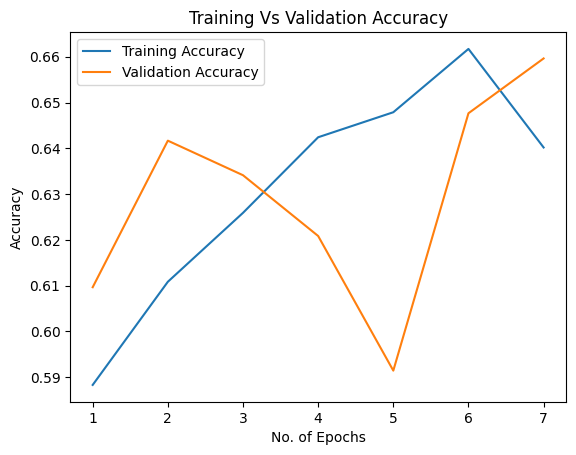

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(history.epoch) + 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Training Vs Validation Accuracy')
plt.legend()
plt.show()

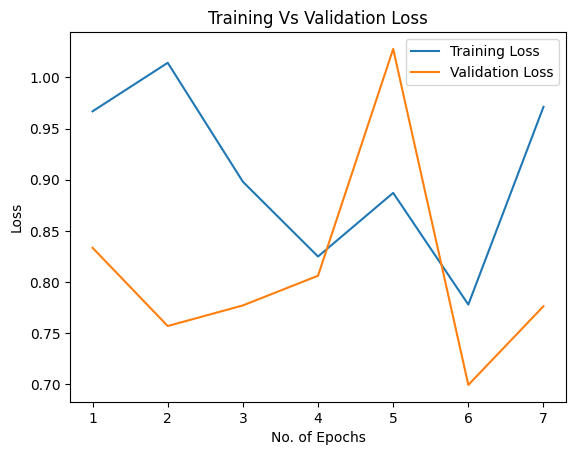

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Training Vs Validation Loss')
plt.legend()
plt.show()